Author: Cezary Januszek

*Created on Saturday, November 15th 2023*
# Flight delays prediction

#### Research question: *What is the influence of the different airlines/airports on the flight delays?*

# IV. Neural Network prediction model

In this last part, a bit more complex model is implemented to try to beat the performance of our baseline Decision Tree. Here once again be optimize our model around the two approaches without the departure delay predictior and with it.

The model of choice is a multi-class classification Multi-Layer Perceptron composed of 3 linear layers with PReLU activation functions and an implicit softamx output layer. The chosen loss function is Cross-entropy and the optimizer is Adam with weight decay.

In [77]:
# Imports
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from IPython.core.pylabtools import figsize
figsize(8, 6)

from helper_functions import *

from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torcheval.metrics.functional import multiclass_confusion_matrix, multiclass_accuracy, multiclass_precision, multiclass_recall, multiclass_auprc, multiclass_f1_score

from captum.attr import IntegratedGradients, DeepLift, GradientShap

from pytorch_tabnet.tab_model import TabNetClassifier
import torch

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using cuda device


In [ ]:
# load the data
data = pd.read_pickle(os.path.abspath('./Data/flights_data.pkl'))

### Last pre-processing step for Neural Network

In [ ]:

# cyclical encoding of time and date to account for cyclicity of time and date
# NOT USED IN THE END AS IT DOES NOT INCREASE PERFORMANCE BUT MAKE INTERPRETABILITY OF FEATURES A BIT MORE DIFFICULT

#data = cyclical_encode(data, 'DAY_OF_WEEK', 7)
#data = cyclical_encode(data, 'DEPARTURE_DAY', 31)
#data = cyclical_encode(data, 'DEPARTURE_MONTH', 12)
#data = cyclical_encode(data, 'ARRIVAL_DAY', 31)
#data = cyclical_encode(data, 'ARRIVAL_MONTH', 12)

#data = cyclical_encode(data, 'SCHEDULED_DEPARTURE_HOUR', 24)
#data = cyclical_encode(data, 'SCHEDULED_DEPARTURE_MIN', 60)
#data = cyclical_encode(data, 'SCHEDULED_ARRIVAL_HOUR', 24)
#data = cyclical_encode(data, 'SCHEDULED_ARRIVAL_MIN', 60)

#data = data.drop(['DAY_OF_WEEK', 'DEPARTURE_DAY', 'DEPARTURE_MONTH', 'ARRIVAL_DAY', 'ARRIVAL_MONTH',
#                             'SCHEDULED_DEPARTURE_HOUR', 'SCHEDULED_DEPARTURE_MIN', 'SCHEDULED_ARRIVAL_HOUR', 'SCHEDULED_ARRIVAL_MIN'], axis=1)


## Multi-layer Perceptron for multi-class classification

In [71]:
#-----------------------------
# Multi-layer Perceptron model
#------------------------------

class MLP(nn.Module):

    def __init__(self, input_size, layer1_size, layer2_size, layer3_size, output_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, layer1_size),
            nn.PReLU(),
            nn.Linear(layer1_size, layer2_size),
            nn.PReLU(),
            nn.Linear(layer2_size, layer3_size),
            nn.PReLU(),
            nn.Linear(layer3_size, output_size)
        )
        self.model.to(device)

    def forward(self, x):
        fwd_output = self.model(x)
        return fwd_output

    def save_model(self, filepath):
        torch.save(self.state_dict(), filepath)

    def load_model(self, filepath):
        self.load_state_dict(torch.load(filepath, map_location=torch.device('cpu')))


'''
#JUST AN IDEA -> NOT USED IN THE END :(

# Define the Attention Layer
class AttentionLayer(nn.Module):

    def __init__(self, input_size):
        super(AttentionLayer, self).__init__()
        self.W_q = nn.Linear(input_size, input_size)
        self.W_k = nn.Linear(input_size, input_size)
        self.W_v = nn.Linear(input_size, input_size)
        self.W_out = nn.Linear(input_size, input_size)

    def forward(self, x):
        x = x.unsqueeze(-1)

        query = self.W_q(x)
        print('Query: ', query.shape)
        key = self.W_k(x)
        print('Key: ', key.shape)
        value = self.W_v(x)

        # Compute attention weights
        attention_weights = torch.softmax(torch.matmul(query, key.transpose(1,2)), dim=-1)
        # Apply attention weights to values
        attention_values = torch.matmul(attention_weights, value).squeeze(-1)
        # Combine attended values using a linear layer
        attention_output = self.W_out(attention_values)

        return attention_output, attention_weights

class AttentionMLP(nn.Module):

    def __init__(self, input_size, layer1_size, layer2_size, layer3_size, output_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, layer1_size),
            nn.PReLU(),
            nn.Linear(layer1_size, layer2_size),
            nn.PReLU(),
            nn.Linear(layer2_size, layer3_size),
            nn.PReLU(),
            AttentionLayer(layer3_size)
        )
        self.output_layer = nn.Linear(layer3_size, output_size)

        self.layers.to(device)
        self.output_layer.to(device)

    def forward(self, x):
        x, attention_weights = self.layers(x)
        x = torch.relu(x)
        fwd_output = self.output_layer(x)

        return fwd_output, attention_weights
'''

#------------------------------------
# Train and validation loop functions
#------------------------------------

def train_loop(model, train_loader, optim, criterion):
  '''
  Training loop function
  '''
  # Mini-batch loop
  #attention_array = []
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    # Zero the gradients for each new mini-batch loop
    optim.zero_grad()
    # Forward pass
    outputs = model(inputs)
    # Compute the loss
    loss = criterion(outputs, labels)
    # Backward pass and optimization
    loss.backward()
    optim.step()

  return loss.item()


def test_loop(model, test_loader, optim, criterion):
  '''
  Validation loop function
  '''
  #attention_array = []
  # No grad computation is needed
  with torch.no_grad():
    for inputs_test, labels_test in test_loader:
      inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
      # Forward pass
      outputs_test = model(inputs_test)
      # Compute the loss
      loss_test = criterion(outputs_test, labels_test)

  return loss_test.item()


def average_test_loss_accuracy(model, test_loader, criterion):
  '''
  Get the average loss and global accuracy on test set
  '''
  with torch.no_grad():
      total_loss_test = 0.0
      correct_predictions_test = 0
      total_samples_test = 0

      for inputs_test, labels_test in test_loader:
          inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)

          outputs_test = model(inputs_test)
          loss_test = criterion(outputs_test, labels_test)
          total_loss_test += loss_test.item()

          _, predicted_test = torch.max(outputs_test, 1)
          correct_predictions_test += (predicted_test == labels_test).sum().item()
          total_samples_test += labels_test.size(0)

      average_loss_test = total_loss_test / len(test_loader)
      accuracy_test = correct_predictions_test / total_samples_test

      print(f'Average test loss: {average_loss_test:.4f}, Accuracy: {accuracy_test * 100:.2f}%')

In [43]:
def visualize_importances(features_df, target):
  '''
  Visualize feature attributions scores
  '''
  print('Target class = ', target)

  plt.figure()
  sns.barplot(features_df, x='Attribution score', y=features_df.index, hue='Method')
  plt.ylabel('Features')
  plt.title('Most important features')
  plt.show()

## Without DEPARTURE_DELAY feature

In [96]:
# separate data into feature matrix X and target variable vector Y
X = pd.get_dummies(data.drop(['DEPARTURE_DELAY', 'ARRIVAL_DELAY'], axis=1))
feature_names = X.columns
Y = data['ARRIVAL_DELAY']

In [97]:
# train-test split with test size of 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
print('Train samples: ', X_train.shape[0])
print('Test samples: ', X_test.shape[0])
print(Counter(Y_train))

# Standardize data
scaler = StandardScaler().fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Training data to tensors
X_train = torch.as_tensor(X_train, dtype=torch.float32, device=device)
Y_train = torch.as_tensor(np.array(Y_train), device=device)
X_test = torch.as_tensor(X_test, dtype=torch.float32, device=device)
Y_test = torch.as_tensor(np.array(Y_test), device=device)

Train samples:  976964
Test samples:  418700
Counter({0: 788206, 1: 128950, 2: 50797, 3: 9011})


In [98]:
# Instantiate the model
mlp_model = MLP(X.shape[1], 50, 50, 50, 4)
# Loss function
#class_weight = torch.tensor([0.1, 0.2, 0.3, 0.4]).to(device)
loss_criterion = nn.CrossEntropyLoss()
# Adam optimizer
# learning rates tested [1-e3, 1e-4, 1e-5]
optimizer = optim.AdamW(mlp_model.parameters(), lr=1e-5)

# Define number of epochs and mini-batch size
num_epochs = 50
# batch sizes tested [500, 1000, 2000]
batch_size = 5000

# DataLoader for creating training and validation batches
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#----------
# Training
#----------

train_loss_array = []
test_loss_array = []
attention_w_array = []

# Epoch loop
for e in range(num_epochs):
  # Training step
  train_loss = train_loop(mlp_model, train_loader, optimizer, loss_criterion)
  # Save epoch loss for plot
  train_loss_array.append(train_loss)
  # Validation step
  test_loss = test_loop(mlp_model, test_loader, optimizer, loss_criterion)
  # Save epoch loss for plot
  test_loss_array.append(test_loss)

  print(f'Epoch [{e+1}/{num_epochs}], Training loss: {train_loss:.4f}, Test loss: {test_loss: 4f}')


Epoch [1/50], Training loss: 1.3378, Test loss:  1.337338
Epoch [2/50], Training loss: 1.3045, Test loss:  1.305838
Epoch [3/50], Training loss: 1.2672, Test loss:  1.266888
Epoch [4/50], Training loss: 1.2187, Test loss:  1.217342
Epoch [5/50], Training loss: 1.1566, Test loss:  1.157681
Epoch [6/50], Training loss: 1.0879, Test loss:  1.089909
Epoch [7/50], Training loss: 1.0035, Test loss:  1.009593
Epoch [8/50], Training loss: 0.9253, Test loss:  0.927979
Epoch [9/50], Training loss: 0.8530, Test loss:  0.837865
Epoch [10/50], Training loss: 0.7684, Test loss:  0.796804
Epoch [11/50], Training loss: 0.7489, Test loss:  0.727750
Epoch [12/50], Training loss: 0.6870, Test loss:  0.686312
Epoch [13/50], Training loss: 0.6635, Test loss:  0.641066
Epoch [14/50], Training loss: 0.6799, Test loss:  0.674743
Epoch [15/50], Training loss: 0.6359, Test loss:  0.653525
Epoch [16/50], Training loss: 0.6363, Test loss:  0.634169
Epoch [17/50], Training loss: 0.6366, Test loss:  0.625786
Epoch 

In [104]:
# save model
mlp_model.save_model(os.path.abspath('./model//mlp_without_DepartureDelay.pt'))

In [99]:
average_test_loss_accuracy(mlp_model, test_loader, loss_criterion)

Average test loss: 0.6167, Accuracy: 80.68%


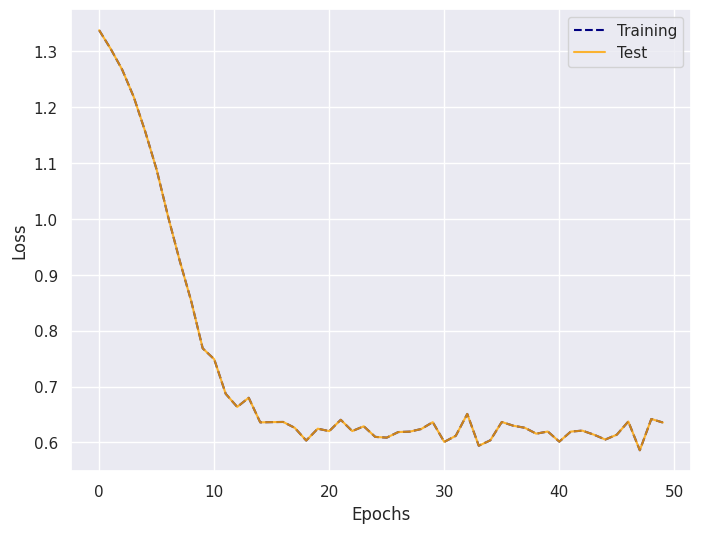

In [100]:
plt.figure()
plt.plot(range(num_epochs), train_loss_array, label='Training', linestyle='dashed', color='navy')
plt.plot(range(num_epochs), train_loss_array, label='Test', alpha=0.8, color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Accuracy = 0.250
Precision = 0.202
Recall = 0.250
F1-score = 0.223
Area under PRC = 0.274


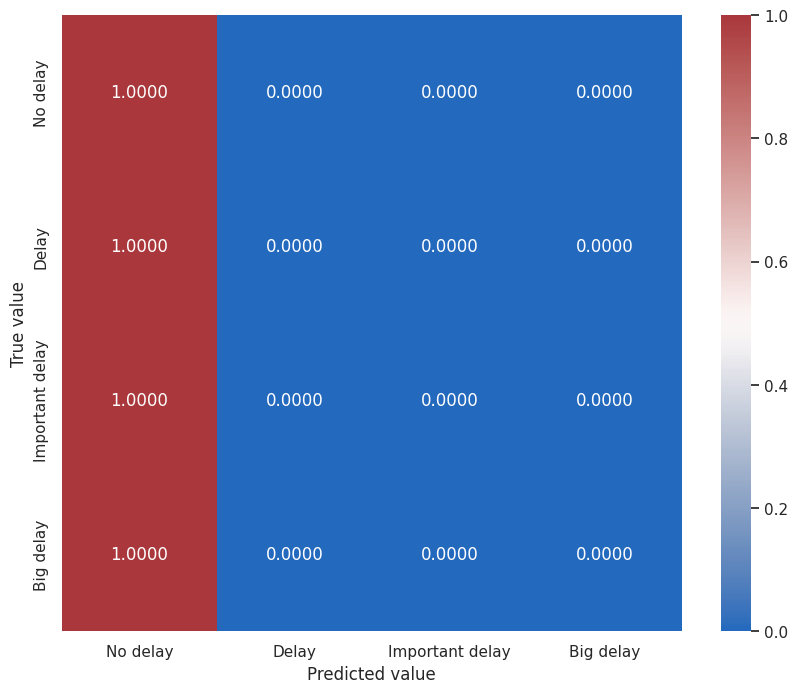

In [101]:
# Evaluate performance with various metrics
Y_pred = mlp_model(X_test)

print('Accuracy = {:.3f}'.format(multiclass_accuracy(Y_pred, Y_test, average='macro', num_classes=4)))
print('Precision = {:.3f}'.format(multiclass_precision(Y_pred, Y_test, average='macro', num_classes=4)))
print('Recall = {:.3f}'.format(multiclass_recall(Y_pred, Y_test, average='macro', num_classes=4)))
print('F1-score = {:.3f}'.format(multiclass_f1_score(Y_pred, Y_test, average='macro', num_classes=4)))
print('Area under PRC = {:.3f}'.format(multiclass_auprc(Y_pred, Y_test, average='macro', num_classes=4)))

conf_matrix = multiclass_confusion_matrix(Y_pred, Y_test, num_classes=4, normalize='true').cpu().numpy()
conf_matrix = pd.DataFrame(conf_matrix, index=['No delay', 'Delay', 'Important delay', 'Big delay'], columns=['No delay', 'Delay', 'Important delay', 'Big delay'])

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, cmap='vlag', fmt='.4f')
plt.ylabel('True value')
plt.xlabel('Predicted value')
plt.show()

## With DEPARTURE_DELAY feature

In [105]:
# separate data into feature matrix X and target variable vector Y
X = pd.get_dummies(data.drop(['ARRIVAL_DELAY'], axis=1))
feature_names = X.columns
Y = data['ARRIVAL_DELAY']

In [106]:
# train-test split with test size of 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
print('Train samples: ', X_train.shape[0])
print('Test samples: ', X_test.shape[0])
print(Counter(Y_train))

# random under-sampling - WORSE PERFORMANCE!
#undersample = RandomUnderSampler(sampling_strategy={0: 400000})
#X_train, Y_train = undersample.fit_resample(X_train, Y_train)
#print('After balancing the classes: ', Counter(Y_train))

# Standardize data
scaler = StandardScaler().fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Training and test data to tensors
X_train = torch.as_tensor(X_train, dtype=torch.float32, device=device)
Y_train = torch.as_tensor(np.array(Y_train), device=device)
X_test = torch.as_tensor(X_test, dtype=torch.float32, device=device)
Y_test = torch.as_tensor(np.array(Y_test), device=device)

Train samples:  976964
Test samples:  418700
Counter({0: 788206, 1: 128950, 2: 50797, 3: 9011})


In [108]:
#------------------------------------
# MODEL, LOSS FUNCTION AND OPTIMIZER
#------------------------------------

# Instantiate the model
mlp_model = MLP(X.shape[1], 100, 50, 100, 4)
# Loss function
loss_criterion = nn.CrossEntropyLoss()
# Adam optimizer
# learning rates tested [1-e3, 1e-4, 1e-5]
optimizer = optim.AdamW(mlp_model.parameters(), lr=1e-5)

# Define number of epochs and mini-batch size
num_epochs = 50
# batch sizes tested [512, 1024, 2000, 5000]
batch_size = 2000

# DataLoader for creating training and validation batches
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#----------
# Training
#----------

train_loss_array = []
test_loss_array = []

# Epoch loop
for e in range(num_epochs):
  # Training step
  train_loss = train_loop(mlp_model, train_loader, optimizer, loss_criterion)
  # Save epoch loss for plot
  train_loss_array.append(train_loss)
  # Validation step
  test_loss = test_loop(mlp_model, test_loader, optimizer, loss_criterion)
  # Save epoch loss for plot
  test_loss_array.append(test_loss)

  print(f'Epoch [{e+1}/{num_epochs}], Training loss: {train_loss:.4f}, Test loss: {test_loss: 4f}')

Epoch [1/50], Training loss: 1.2567, Test loss:  1.257908
Epoch [2/50], Training loss: 0.9764, Test loss:  0.986905
Epoch [3/50], Training loss: 0.6824, Test loss:  0.708618
Epoch [4/50], Training loss: 0.6159, Test loss:  0.616688
Epoch [5/50], Training loss: 0.6295, Test loss:  0.608644
Epoch [6/50], Training loss: 0.5731, Test loss:  0.523699
Epoch [7/50], Training loss: 0.5453, Test loss:  0.482830
Epoch [8/50], Training loss: 0.5075, Test loss:  0.559331
Epoch [9/50], Training loss: 0.4936, Test loss:  0.511435
Epoch [10/50], Training loss: 0.4193, Test loss:  0.462110
Epoch [11/50], Training loss: 0.4217, Test loss:  0.443755
Epoch [12/50], Training loss: 0.4038, Test loss:  0.421620
Epoch [13/50], Training loss: 0.3696, Test loss:  0.412269
Epoch [14/50], Training loss: 0.3349, Test loss:  0.309193
Epoch [15/50], Training loss: 0.3481, Test loss:  0.301187
Epoch [16/50], Training loss: 0.3141, Test loss:  0.345425
Epoch [17/50], Training loss: 0.3382, Test loss:  0.299243
Epoch 

In [113]:
# save model
mlp_model.save_model(os.path.abspath('./model/mlp_with_DepartureDelay.pt'))

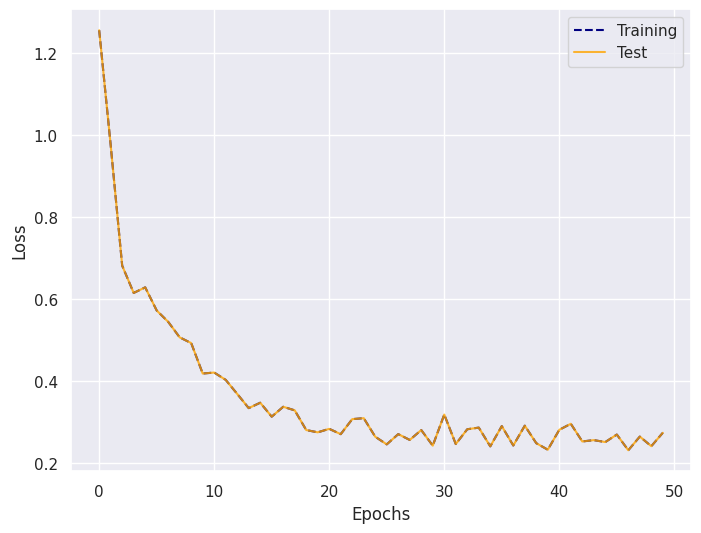

In [112]:
plt.figure()
plt.plot(range(num_epochs), train_loss_array, label='Training', linestyle='dashed', color='navy')
plt.plot(range(num_epochs), train_loss_array, label='Test', alpha=0.8, color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [110]:
# Test the model
average_test_loss_accuracy(mlp_model, test_loader, loss_criterion)

Average test loss: 0.2703, Accuracy: 90.73%


Accuracy = 0.785
Precision = 0.853
Recall = 0.785
F1-score = 0.814
Area under PRC = 0.717


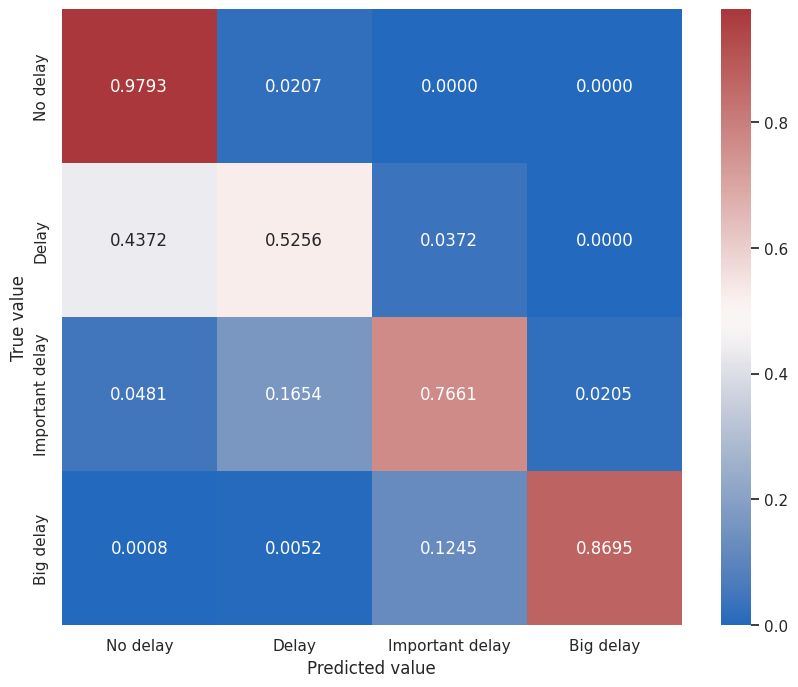

In [111]:
# Evaluate performance with various metrics
Y_pred = mlp_model(X_test)

print('Accuracy = {:.3f}'.format(multiclass_accuracy(Y_pred, Y_test, average='macro', num_classes=4)))
print('Precision = {:.3f}'.format(multiclass_precision(Y_pred, Y_test, average='macro', num_classes=4)))
print('Recall = {:.3f}'.format(multiclass_recall(Y_pred, Y_test, average='macro', num_classes=4)))
print('F1-score = {:.3f}'.format(multiclass_f1_score(Y_pred, Y_test, average='macro', num_classes=4)))
print('Area under PRC = {:.3f}'.format(multiclass_auprc(Y_pred, Y_test, average='macro', num_classes=4)))

conf_matrix = multiclass_confusion_matrix(Y_pred, Y_test, num_classes=4, normalize='true').cpu().numpy()
conf_matrix = pd.DataFrame(conf_matrix, index=['No delay', 'Delay', 'Important delay', 'Big delay'], columns=['No delay', 'Delay', 'Important delay', 'Big delay'])

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, cmap='vlag', fmt='.4f')
plt.ylabel('True value')
plt.xlabel('Predicted value')
plt.show()

## Model predictions interpretation with *Captum*

Captum is a model interpretability and understanding library for PyTorch models, developed by Facebook AI. We use this library to get attribution scores for our predictions to better understand the influence of input features on the output for each of the 4 target classes.

Within this library, several primary attribution agorithms are tested to compute the attributions:

1.   **Integrated gradients** - a back-propagation method that assigns an importance score to each of the input features by approximating the integral of the gradients of the model's outputs with respect to the inputs along the path from a baseline to an input.
2.  **DeepLIFT** - another back-propagation method assigning relevance scores to input features based on the difference between an input and a reference input fro non-linear activations.
3. **Gradient SHAP** - gradient method to compute SHAP values

In [115]:
# load model specs
mlp = MLP(X.shape[1], 100, 50, 100, 4)
mlp.load_model(os.path.abspath('./model/mlp_with_DepartureDelay.pt'))

batch_size = 2000
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Target class =  0


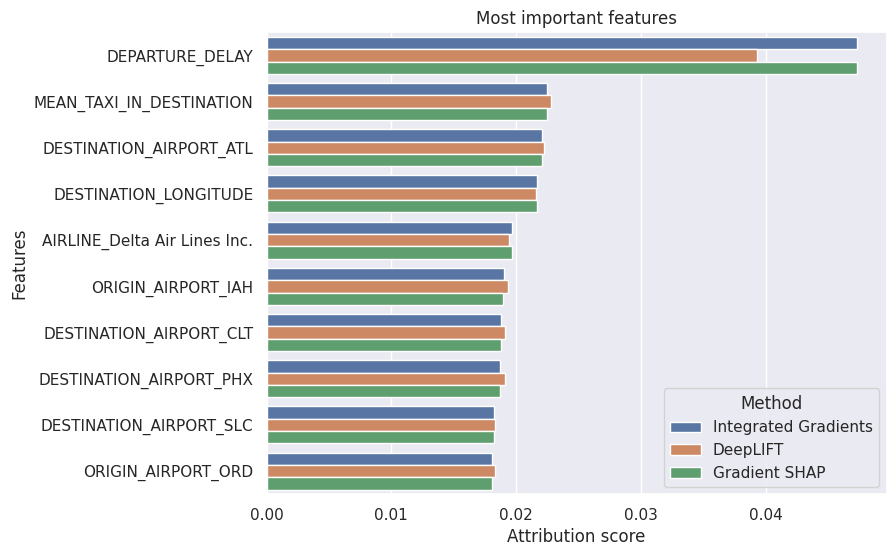

Target class =  1


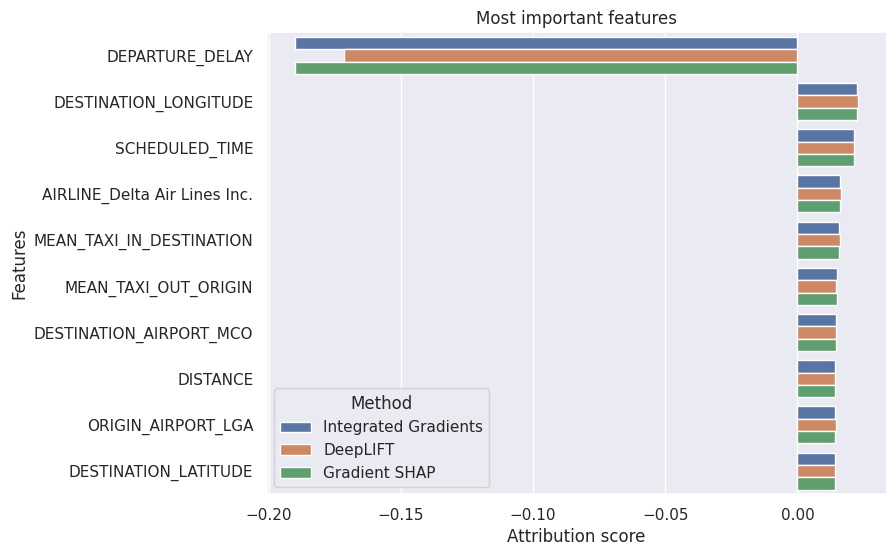

Target class =  2


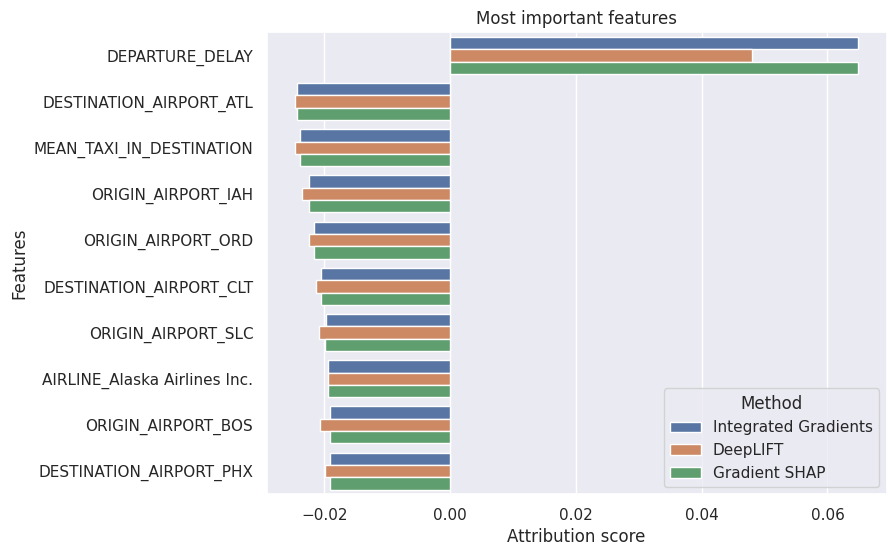

Target class =  3


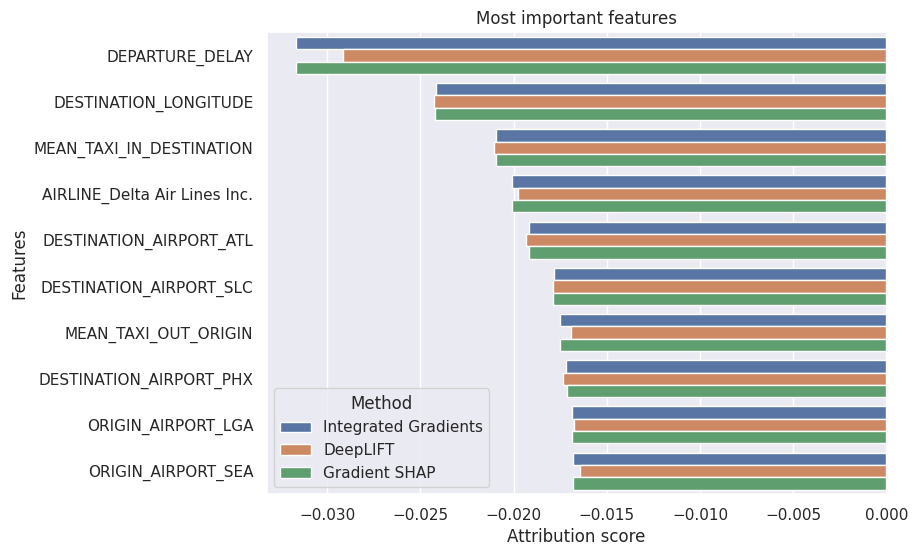

In [116]:

# run the 3 attributions algorithm for all 4 target classes
for t in range(4):
    ig_array = []
    dl_array = []
    gs_array = []
    for test_tensor_input, _ in test_loader:
        test_tensor_input = test_tensor_input.to(device)
        # baseline tensor of 0
        baseline = torch.zeros(test_tensor_input.shape).to(device)

        # compute feature attribution with Integrated gradients, DeepLIFT and Gradient SHAP
        ig = IntegratedGradients(mlp)
        dl = DeepLift(mlp)
        gs = GradientShap(mlp)
        ig_attributions, ig_delta = ig.attribute(test_tensor_input, baseline, target=t, return_convergence_delta=True)
        dl_attributions, dl_delta = dl.attribute(test_tensor_input, baseline, target=t, return_convergence_delta=True)
        gs_attributions, gs_delta = gs.attribute(test_tensor_input, baseline, target=t, return_convergence_delta=True)
        # normalize attributions
        ig_attributions_sum = ig_attributions.detach().cpu().numpy().sum(0)
        ig_attributions = ig_attributions_sum/np.linalg.norm(ig_attributions_sum, ord=1)
        dl_attributions_sum = dl_attributions.detach().cpu().numpy().sum(0)
        dl_attributions = dl_attributions_sum/np.linalg.norm(dl_attributions_sum, ord=1)
        gs_attributions_sum = gs_attributions.detach().cpu().numpy().sum(0)
        gs_attributions = gs_attributions_sum/np.linalg.norm(gs_attributions_sum, ord=1)
        # add feature attributions from batch
        ig_array.append(ig_attributions)
        dl_array.append(dl_attributions)
        gs_array.append(gs_attributions)

    # mean attributions over batches
    ig_attributions = np.array(ig_array).mean(axis=0)
    dl_attributions = np.array(dl_array).mean(axis=0)
    gs_attributions = np.array(gs_array).mean(axis=0)

    # dataframe of feature attributions
    feature_importance_df = pd.DataFrame(data=ig_attributions, index=feature_names, columns=['Integrated Gradients'])
    feature_importance_df['DeepLIFT'] = dl_attributions
    feature_importance_df['Gradient SHAP'] = gs_attributions
    most_important_features = feature_importance_df.abs().sort_values('Integrated Gradients', ascending=False).head(10).index
    feature_importance_df = feature_importance_df.loc[most_important_features].stack().reset_index(level=1)
    feature_importance_df.columns = ['Method', 'Attribution score']

    # show plot
    visualize_importances(feature_importance_df, t)


## TabNet - an attentive tabular learning model

Additionally a recently developed deep learning model is tested that pretends to be able to compete with boosting methods in terms of prediction performance on tabular data, at the same time offering a great interpretability. 

TabNet is a deep tabular data learning architecture developed at Google Cloud AI that uses sequential attention to choose which features to reason from at each decision step, enabling interpretability and more efficient learning. The TabNet encoder is composed of a feature transformer, an attentive transformer and feature masking.

In [117]:
# separate data into feature matrix X and target variable vector Y
X = pd.get_dummies(data.drop(['ARRIVAL_DELAY'], axis=1))
feature_names = X.columns
Y = data['ARRIVAL_DELAY']

# train-test split with test size of 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
print('Train samples: ', X_train.shape[0])
print('Test samples: ', X_test.shape[0])

Train samples:  976964
Test samples:  418700


In [119]:
# Model definition
tabnet = TabNetClassifier(optimizer_fn=torch.optim.Adam, scheduler_params={"step_size":10, "gamma":0.9}, scheduler_fn=torch.optim.lr_scheduler.StepLR,)

# fit the model
tabnet.fit(X_train.values, Y_train.values, eval_set=[(X_train.values, Y_train.values), (X_test.values, Y_test.values)], eval_metric=['balanced_accuracy'], max_epochs=50,
           eval_name=['train', 'test'], weights=1)

epoch 0  | loss: 0.56156 | train_balanced_accuracy: 0.81968 | test_balanced_accuracy: 0.81736 |  0:01:06s
epoch 1  | loss: 0.4631  | train_balanced_accuracy: 0.82113 | test_balanced_accuracy: 0.81864 |  0:02:13s
epoch 2  | loss: 0.45425 | train_balanced_accuracy: 0.82012 | test_balanced_accuracy: 0.81814 |  0:03:20s
epoch 3  | loss: 0.4484  | train_balanced_accuracy: 0.82195 | test_balanced_accuracy: 0.81922 |  0:04:27s
epoch 4  | loss: 0.44307 | train_balanced_accuracy: 0.82419 | test_balanced_accuracy: 0.81883 |  0:05:34s
epoch 5  | loss: 0.43702 | train_balanced_accuracy: 0.82213 | test_balanced_accuracy: 0.8163  |  0:06:40s
epoch 6  | loss: 0.43236 | train_balanced_accuracy: 0.82724 | test_balanced_accuracy: 0.82066 |  0:07:46s
epoch 7  | loss: 0.43011 | train_balanced_accuracy: 0.82249 | test_balanced_accuracy: 0.81322 |  0:08:53s
epoch 8  | loss: 0.42588 | train_balanced_accuracy: 0.82714 | test_balanced_accuracy: 0.81895 |  0:10:00s
epoch 9  | loss: 0.42295 | train_balanced_accu

Text(0, 0.5, 'Training loss')

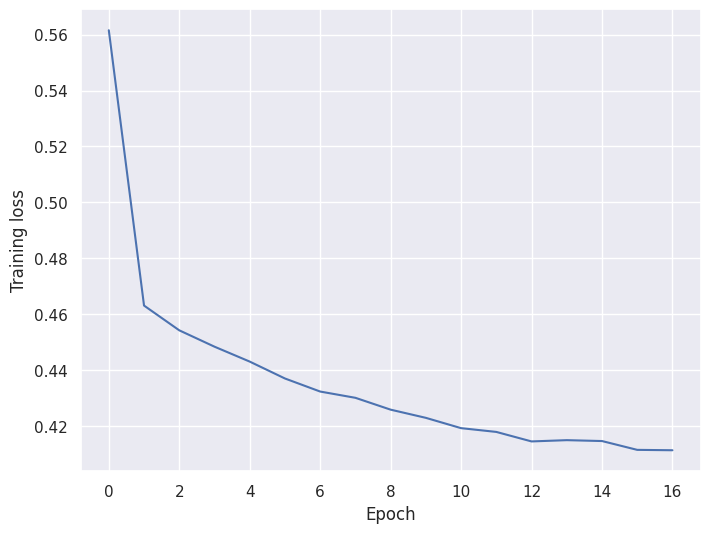

In [124]:
# plot losses
plt.plot(tabnet.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Training loss')

<Axes: xlabel='Feature_importance'>

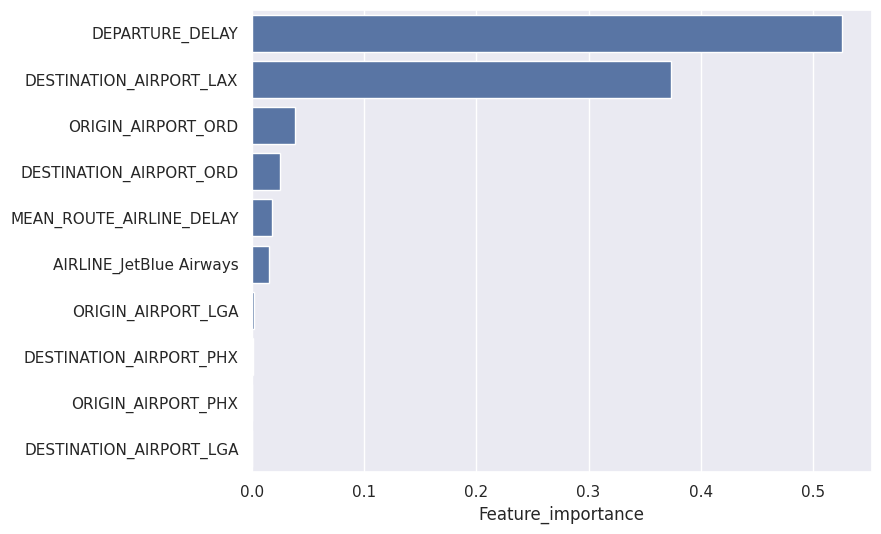

In [134]:
feat_importances = tabnet.feature_importances_
feat_df = pd.DataFrame(data=feat_importances, index=X.columns, columns=['Feature_importance']).sort_values('Feature_importance', ascending=False).head(10)

# plot
plt.figure()
sns.barplot(x=feat_df['Feature_importance'], y=feat_df.index, color='b')

Cross-entropy loss = 0.453
Accuracy = 0.821
Precision = 0.733
Recall = 0.821
F1-score = 0.769


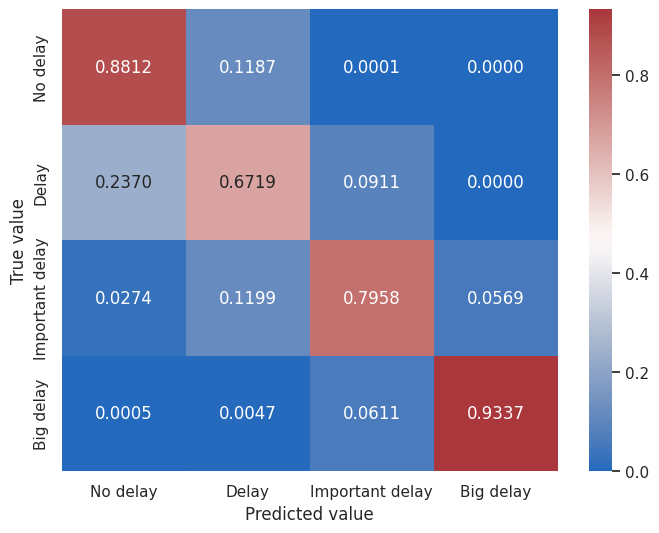

In [144]:
# Evaluate performance with various metrics
y_pred, _ = clf_evaluate_metrics(tabnet, X_test.values, Y_test.values)